In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from numpy.random import normal
from numpy import clip, random
from torch.utils.data import DataLoader
from torch import cuda, optim, save, load, float32
from torchvision import transforms
from torch import tensor
from torchvision.datasets import MNIST
from torch.autograd import Variable
from torch.nn.functional import mse_loss
from torch import nn
from time import time, sleep
from PIL import Image


batch = 300
epoch = 10
learning_rate = 0.0003 


def check_model(model, dataset, num_of_example=10, fig_size=(100,30)):
    """
    Show num_of_example image, noised image and restored image by model.
    :param mosel: Model for denoising. 
    :param dataset: Dataset for testing. 
    :param num_of_example: Number of example for demonstration.
    :param fig_size: Size of canvas for demonstration. 
    """
    plt.figure(figsize = fig_size)
    indexes = [random.randint(len(dataset)) for x in range(num_of_example)]
    for step, index in enumerate(indexes):
        img, noise, _ = dataset[index]
        restore = model(img.reshape((1,1,28,28)))
        ax = plt.subplot(3, num_of_example, step+1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(img.reshape(28,28))
        ax = plt.subplot(3, num_of_example, (num_of_example*1)+step+1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(noise.reshape(28,28))
        ax = plt.subplot(3, num_of_example, (num_of_example*2)+step+1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(restore.detach().numpy().reshape(28,28))
    plt.gray()
    plt.show()


def check_dataloader(dataset, num_of_example=10, fig_size=(80,20)):
    """
    Show num_of_example image and noised image. 
    :param dataset: Dataset for testing. 
    :param num_of_example: Number of example for demonstration.
    :param fig_size: Size of canvas for demonstration. 
    """
    plt.figure(figsize = fig_size)
    plt.gray()
    indexes = [random.randint(len(dataset)) for x in range(num_of_example)]
    for step, index in enumerate(indexes):
        img, noise, _ = dataset[index]
        ax = plt.subplot(3, num_of_example, step+1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(img.reshape(28,28))
        ax = plt.subplot(3, num_of_example, (num_of_example*1)+step+1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(noise.reshape(28,28))
    plt.show()
    

class AddNoise(object):
    """
    Transformation for add gaussian noise to image.
    Tutor: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    """
    def __init__(self, noise_factor=0.5):
        """
        Set  noise factor. 
        :param noise_factor:  Noise factor.
        """
        self.__noise_factor = noise_factor

    def __call__(self, sample):
        """
        Add gaussian noise to input image.
        Formula is taken from: https://blog.keras.io/building-autoencoders-in-keras.html
        :param sample: Input image.
        :return: Image  with noise.
        """
        return clip(sample + tensor(self.__noise_factor*normal(0, 1, sample.shape), dtype=float32), 0, 1) 
    
    
class NoiseMNISTDataset(MNIST):
    """
    Custom dataset class for MNIST dataset with gaussian noise image. 
    Parent class realisation: https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py
    """
    
    def __init__(self, root, train=True, transform=None, target_transform=None,
                 download=False, noise_factor=0.5):
        """
        MNIST dataset `MNIST <http://yann.lecun.com/exdb/mnist/>` with noised image.
        :param root (string): Root directory of dataset where ``MNIST/processed/training.pt``
        and  ``MNIST/processed/test.pt`` exist.
        :param train (bool, optional): If True, creates dataset from ``training.pt``,
        otherwise from ``test.pt``.
        :param download (bool, optional): If true, downloads the dataset from the internet and
        puts it in root directory. If dataset is already downloaded, it is not
        downloaded again.
        :param transform (callable, optional): A function/transform that  takes in an PIL image
        and returns a transformed version. E.g, ``transforms.RandomCrop``
        :param target_transform (callable, optional): A function/transform that takes in the
        target and transforms it.
        :param noise_factor: Percent of noise in image.
        """
        super(NoiseMNISTDataset, self).__init__(root, train, transform, 
                                                target_transform, download)
        self.Noiser = AddNoise(noise_factor)
        
    def __getitem__(self, index):
        """
        Return transformed data (Original MNIST image, noised image and label) by index. 
        :param index: Index of image wich need be to return. 
        :return: Original MNIST image, noised image and label. 
        """
        img, target = self.data[index], int(self.targets[index])
        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)
            
        noise = self.Noiser(img)
        return img, noise, target    
    
    
simple = transforms.Compose([transforms.ToTensor()])
train_noised = NoiseMNISTDataset('./mnist', download=True,  transform=simple, noise_factor=0.3)
test_noised = NoiseMNISTDataset('./mnist', train=False, download=True, transform=simple, noise_factor=0.3)

train = DataLoader(train_noised, batch_size=batch, pin_memory=True, drop_last=True)
test = DataLoader(test_noised, batch_size=batch, pin_memory=True, drop_last=True)

Train Dataset:  Dataset NoiseMNISTDataset
    Number of datapoints: 60000
    Root location: ./mnist
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


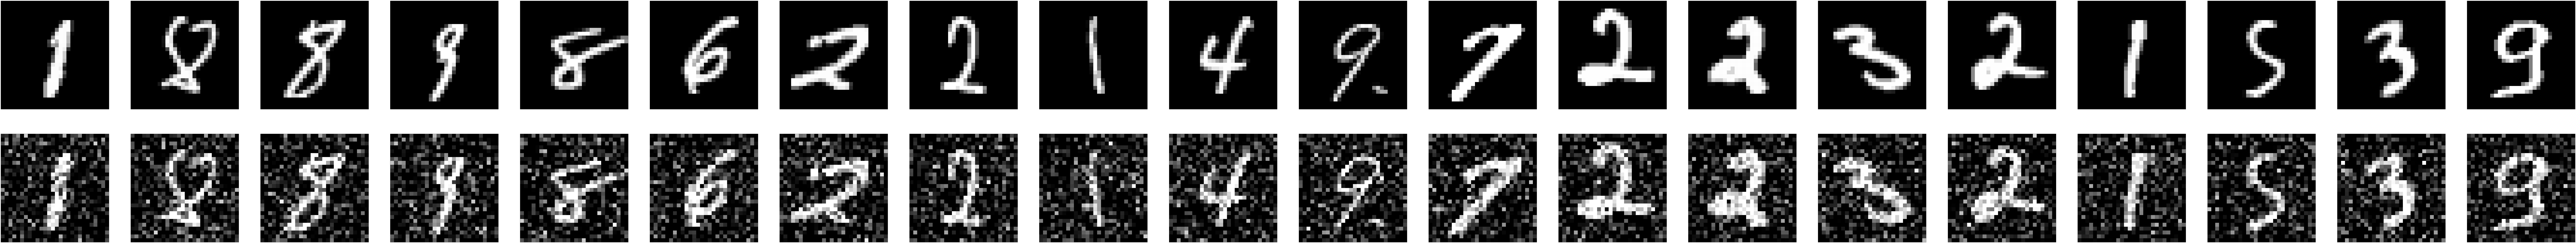

Test Dataset:  Dataset NoiseMNISTDataset
    Number of datapoints: 10000
    Root location: ./mnist
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


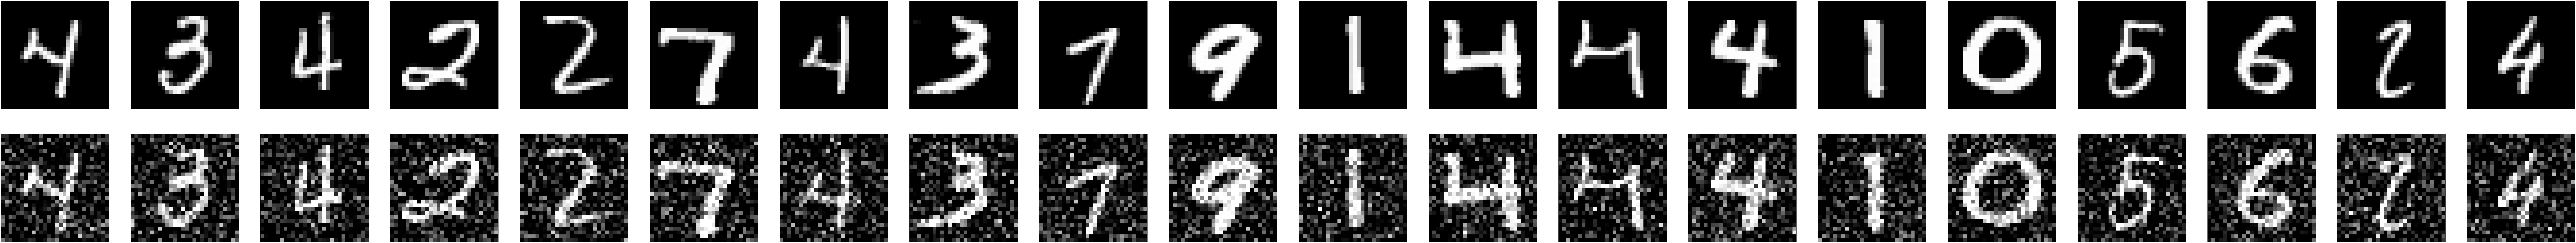

In [2]:
print("Train Dataset: ", train.dataset)
check_dataloader(train_noised, 20, (400, 60))
print("Test Dataset: ", test.dataset)
check_dataloader(test_noised, 20, (400, 60))

In [3]:
class DenoiseModelSmall(nn.Module):
    """
    Small autoencoder model for MNIST image denoising.
    Based on keras tutor: https://blog.keras.io/building-autoencoders-in-keras.html.
    """
    def __init__(self):
        """
        Initializes small autoencoder. Initializes internal Module state, shared by both nn.Module 
        and ScriptModule.
        """
        super(DenoiseModelSmall, self).__init__()
        self.encoder = nn.Sequential(
                         nn.Conv2d(1, 32, 3, padding=1),  # batch x 32 x 28 x 28
                         nn.ReLU(),
                         nn.MaxPool2d(2),  # batch x 32 x 14 x 14
                         nn.Conv2d(32, 32, 3, padding=1),  # batch x 32 x 14 x 14
                         nn.ReLU(),
                         nn.MaxPool2d(2)  # batch x 32 x 7 x 7
        )
        self.decoder = nn.Sequential(
                         nn.ConvTranspose2d(32, 32, 3, 2, 1, 1), # batch x 32 x 14 x 14
                         nn.ReLU(),
                         nn.ConvTranspose2d(32, 32, 3, 1, 1),  # batch x 32 x 14 x 14
                         nn.ReLU(),
                         nn.ConvTranspose2d(32, 1, 3, 2, 1, 1),  # batch x 1 x 28 x 28
                         nn.ReLU()
        )
        
    def forward(self, x):
        """
        Defines the computation performed at every call.           
        :param x: Batch of images in format: BxCxHxW
        :return: Image after autoencoder.
        """
        out = self.encoder(x)
        out = self.decoder(out)
        return out
    
class DenoiseModel(nn.Module):
    """
    Autoencoder model for MNIST imege denoising.
    """
    def __init__(self): 
        """
        Initializes autoencoder. Initializes internal Module state, shared by both nn.Module and ScriptModule.
        """
        super(DenoiseModel,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,32,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,32,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 64 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(64,64,3,padding=1),  # batch x 64 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)  # batch x 64 x 14 x 14
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),  # batch x 128 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128,128,3,padding=1),  # batch x 128 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),  # batch x 256 x 7 x 7
                        nn.Conv2d(128,256,3,padding=1),  # batch x 256 x 7 x 7
                        nn.ReLU()
        
        )
        self.layer3 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1),  # batch x 128 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,128,3,1,1),  # batch x 128 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.ConvTranspose2d(64,64,3,1,1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer4 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,3,1,1),  # batch x 32 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,32,3,1,1),  # batch x 32 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,1,3,2,1,1),  # batch x 1 x 28 x 28
                        nn.ReLU()
        )
        
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out
    

In [4]:
# Train small model.
cuda_ = cuda.is_available()
print('Cuda is aviable: ', cuda_)

if cuda_:
    denoiser = DenoiseModelSmall().cuda()
else: 
    denoiser = DenoiseModelSmall()
denoiser.train()
   
optimizer = optim.Adam(denoiser.parameters(), lr=0.00003 )

st = time()
for i in range(epoch):
    loss_avg = 0
    ep = 0
    epoch_st = time()
    for image, image_noised, label in train: 
        if cuda:
            image = Variable(image).cuda()
            image_noised = Variable(image_noised).cuda()
        else: 
            image = Variable(image)
            image_noised = Variable(image_noised)
        optimizer.zero_grad()
        output = denoiser(image_noised)
        loss = mse_loss(output, image)
        loss.backward()
        optimizer.step()
        loss_avg += loss.item()
        ep += 1
    loss_avg /= ep  
    print('Epoch №{}/{}, Loss: {}, Time per epoch: {}'.format(i+1, epoch, loss_avg, (time() - epoch_st)))
    save(denoiser.state_dict(), 'data/small_epoch{}_loss{}.pth'.format(i+1, loss_avg))
print('Training time:', time()-st)

Cuda is aviable:  True
Epoch №1/10, Loss: 0.08686076356098056, Time per epoch: 17.532562017440796
Epoch №2/10, Loss: 0.05134192073717713, Time per epoch: 17.140095710754395
Epoch №3/10, Loss: 0.033162122797220944, Time per epoch: 17.224711894989014
Epoch №4/10, Loss: 0.02539114661514759, Time per epoch: 17.366044759750366
Epoch №5/10, Loss: 0.020545883439481258, Time per epoch: 17.366829872131348
Epoch №6/10, Loss: 0.017734966110438108, Time per epoch: 17.59054923057556
Epoch №7/10, Loss: 0.01590553845278919, Time per epoch: 16.96580696105957
Epoch №8/10, Loss: 0.014441855270415544, Time per epoch: 17.017557859420776
Epoch №9/10, Loss: 0.013374477284960449, Time per epoch: 17.642228841781616
Epoch №10/10, Loss: 0.012579054669477046, Time per epoch: 17.599205255508423
Training time: 173.4609830379486


In [6]:
# Train big model.
cuda_ = cuda.is_available()
print('Cuda is aviable: ', cuda_)

if cuda_:
    denoiser = DenoiseModel().cuda()
else: 
    denoiser = DenoiseModel()
denoiser.train()
   
optimizer = optim.Adam(denoiser.parameters(), lr=learning_rate)

st = time()
for i in range(epoch):
    loss_avg = 0
    ep = 0
    epoch_st = time()
    for image, image_noised, label in train: 
        if cuda:
            image = Variable(image).cuda()
            image_noised = Variable(image_noised).cuda()
        else: 
            image = Variable(image)
            image_noised = Variable(image_noised)
        optimizer.zero_grad()
        output = denoiser(image_noised)
        loss = mse_loss(output, image)
        loss.backward()
        optimizer.step()
        loss_avg += loss.item()
        ep += 1
    loss_avg /= ep  
    print('Epoch №{}/{}, Loss: {}, Time per epoch: {}'.format(i+1, epoch, loss_avg, (time() - epoch_st)))
    save(denoiser.state_dict(), 'data/big_epoch{}_loss{}.pth'.format(i+1, loss_avg))
print('Training time:', time()-st)

Cuda is aviable:  True
Epoch №1/10, Loss: 0.05207396601792425, Time per epoch: 34.12287163734436
Epoch №2/10, Loss: 0.011701925522647798, Time per epoch: 34.06989312171936
Epoch №3/10, Loss: 0.009445703644305468, Time per epoch: 34.24872088432312
Epoch №4/10, Loss: 0.008388887515757233, Time per epoch: 34.332146883010864
Epoch №5/10, Loss: 0.00774892995133996, Time per epoch: 34.392072677612305
Epoch №6/10, Loss: 0.007294101666193455, Time per epoch: 33.22174572944641
Epoch №7/10, Loss: 0.0069658208405599, Time per epoch: 33.236024141311646
Epoch №8/10, Loss: 0.006712468049954623, Time per epoch: 33.83049488067627
Epoch №9/10, Loss: 0.006490250939968974, Time per epoch: 35.35266733169556
Epoch №10/10, Loss: 0.0063252408034168185, Time per epoch: 34.42947816848755
Training time: 341.3068697452545


In [5]:
def restor_model(base_class, path): 
    model = base_class()
    state = load(path)
    model.load_state_dict(state)
    model.eval()
    return model

In [8]:
model_small = restor_model(DenoiseModelSmall, 'data/small_epoch10_loss0.012579054669477046.pth')
model_big = restor_model(DenoiseModel, 'data/big_epoch10_loss0.0063252408034168185.pth')

Result of big model: 


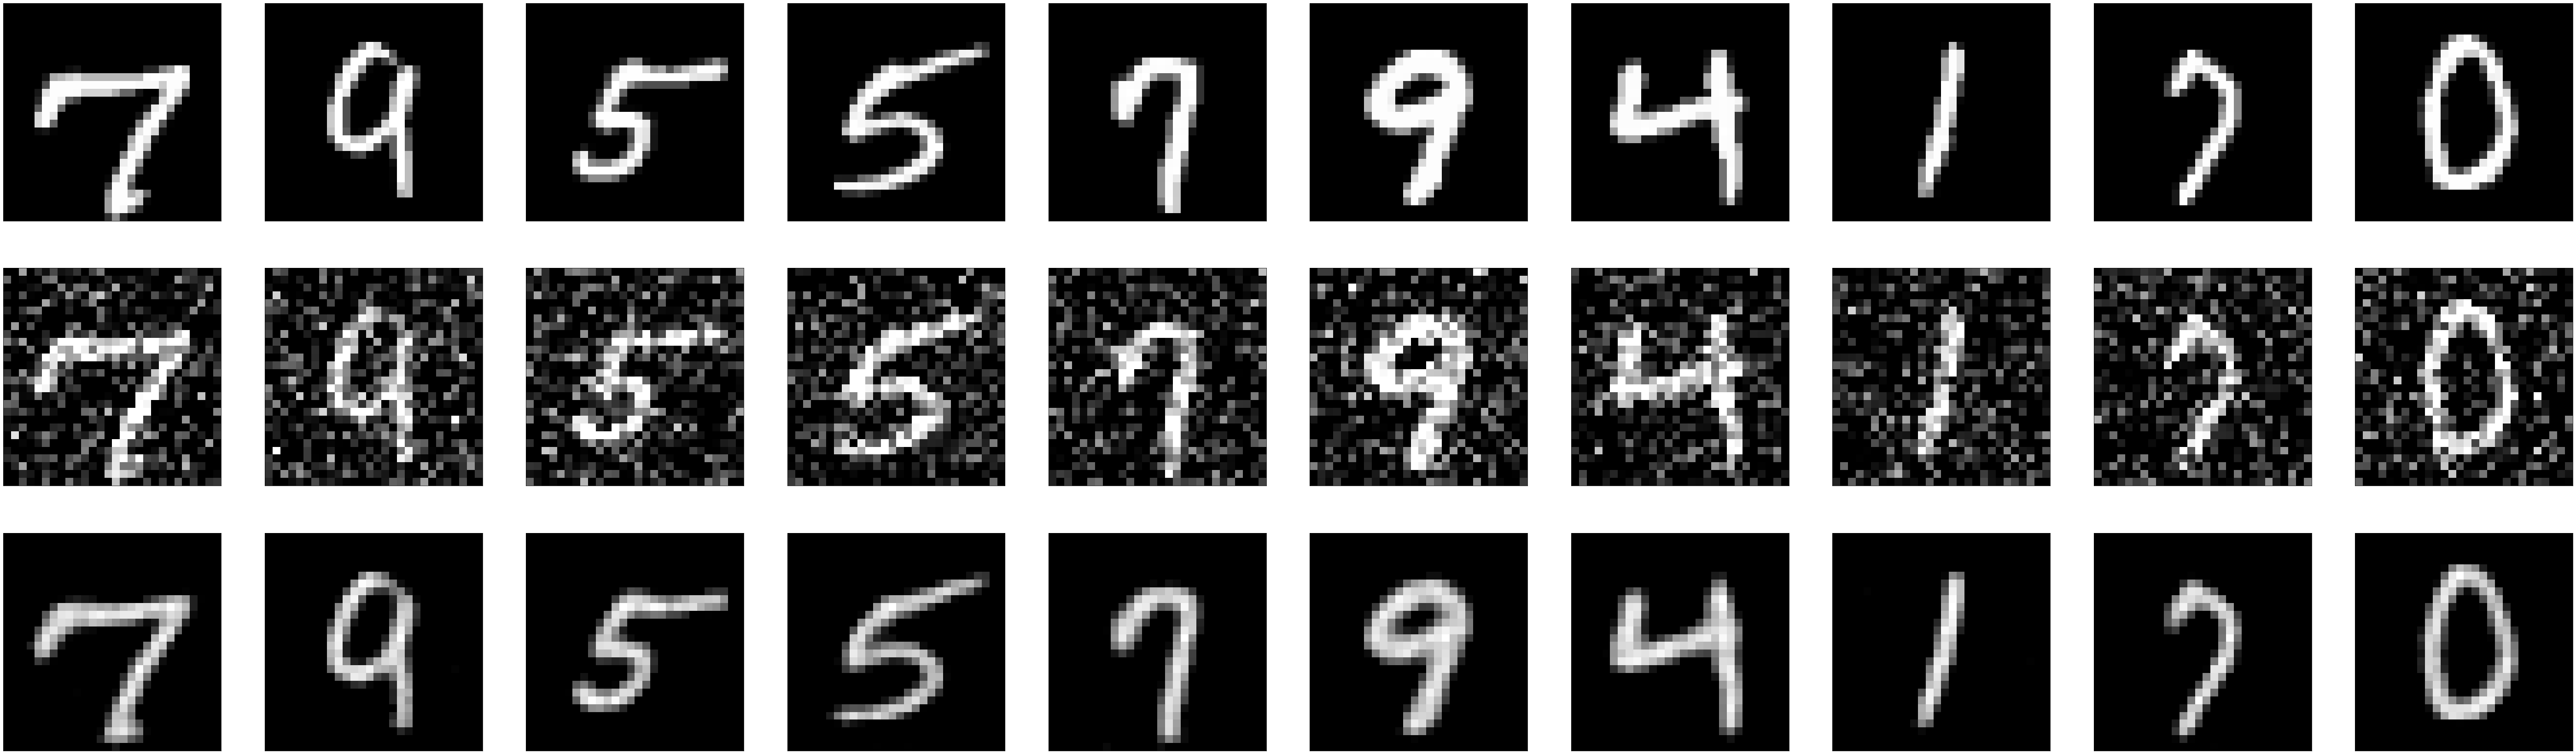

Result of small model: 


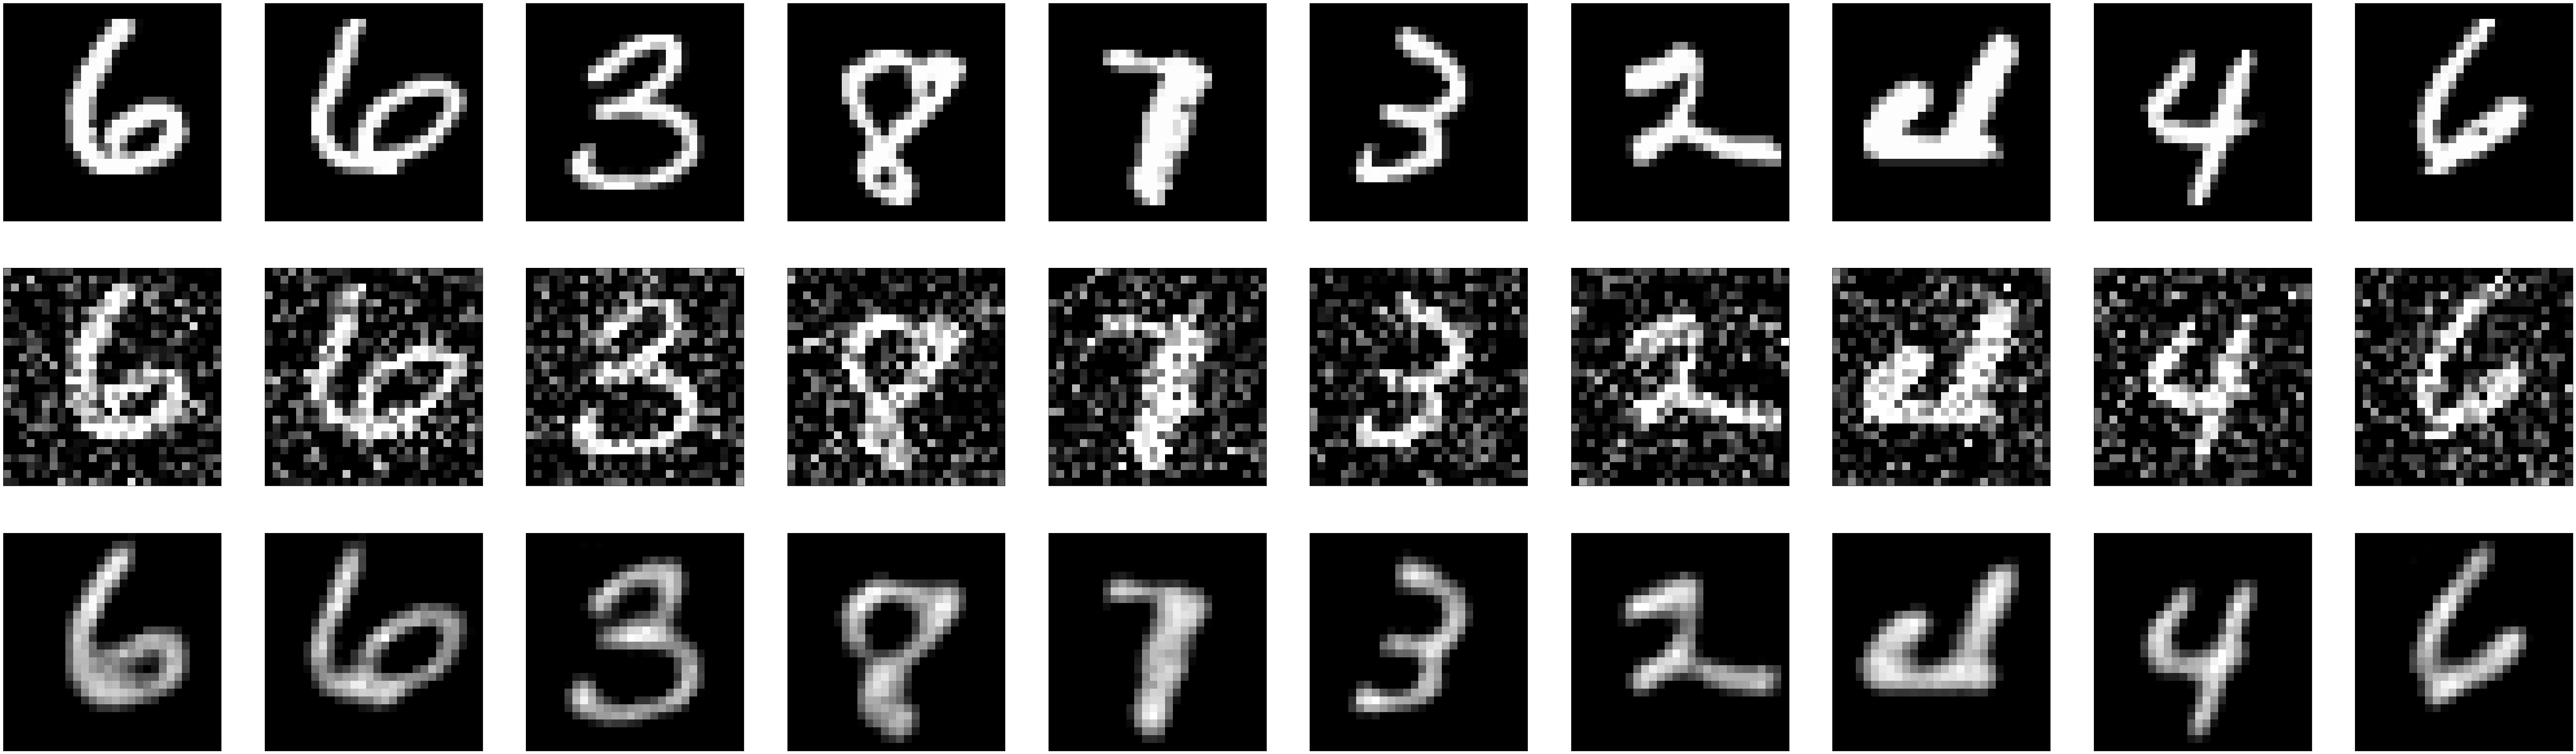

In [10]:
print("Result of big model: ")
check_model(model_big, test_noised)
print("Result of small model: ")
check_model(model_small, test_noised)